In [14]:
import json, pickle
import glob, os

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit, modify_and_add_noise_to_model
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel

from functools import partial

In [2]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

num_qubit = 4

In [3]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_coherent, noise_model = modify_and_add_noise_to_model()

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_coherent = {'shots': 10000, 'backend': backend_noisy_coherent, 'name': 'noisy_coherent'}

num_qubit = 4

In [4]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [5]:
from qiskit.transpiler.exceptions import TranspilerError
import scipy

def generate_data(generating_func, two_q_gate_depths, save_path: str, n_entries_per_file: int):
    for depth in two_q_gate_depths:
        entries = []

        for i in tqdm(range(n_entries_per_file)):
            success = False
            while not success:
                try:
                    circuit = generating_func(depth)
                    success = True
                except (scipy.linalg.LinAlgError, TranspilerError, np.linalg.LinAlgError) as e:
                    print(f"Ran into an error:, {e}")

            job_ideal = execute(circuit, **run_config_ideal)
            job_noisy = execute(circuit, **run_config_noisy_coherent)

            counts_ideal = job_ideal.result().get_counts()
            counts_noisy = job_noisy.result().get_counts()

            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)

            graph_data = circuit_to_graph_data_json(
                circuit=circuit,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )

            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=ideal_exp_val.tolist(),
                noisy_exp_values=[noisy_exp_val.tolist()],
                circuit_depth=circuit.depth()
            )
            to_append = entry.to_dict()
            to_append['circuit'] = circuit
            entries.append(to_append)

        path = f"{save_path}/step_{depth}.pk"
        with open(path, "wb") as f:
            pickle.dump(entries, f)

# Sanity check on the all-z expectation value of the generated random Cliffords

In [7]:
from qiskit.transpiler.exceptions import TranspilerError

out = []
for _ in tqdm(range(1000)):
    d = random.choice(np.arange(0, 19, 2))
    circuit, _ = construct_random_clifford(num_qubit, d)

    success = False
    while not success:
        try:
            circuit = transpile(circuit, backend_noisy, optimization_level=3)
            success = True
        except TranspilerError as e:
            print(f'Run into {e}')

    job_ideal = execute(circuit, **run_config_ideal)
    counts_ideal = job_ideal.result().get_counts()
    ideal_exp_val = cal_all_z_exp(counts_ideal)
    out.append(ideal_exp_val)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, '1000 "random" clifford all-Z expectation')

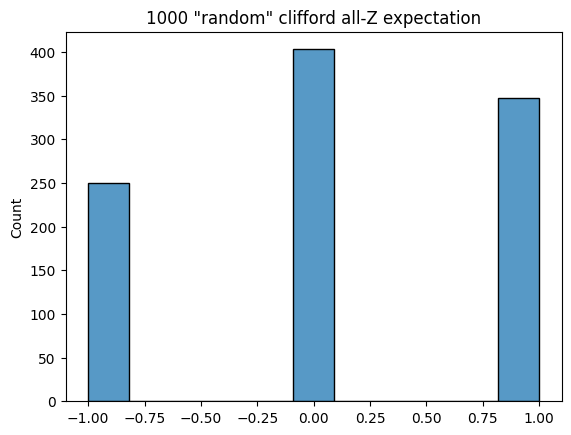

In [8]:
sns.histplot(out)
plt.title('1000 "random" clifford all-Z expectation')

# Generate cliffords

In [9]:
num_qubit = 4

def construct_random_clifford_func(two_q_gate_depth_post_trans, be):
    if two_q_gate_depth_post_trans in [6, 8, 16, 18]: factor = 1.2
    elif two_q_gate_depth_post_trans in [2]: factor = 0.5
    elif two_q_gate_depth_post_trans in [4, 10, 12, 14]: factor = 1

    if not two_q_gate_depth_post_trans:
        d = np.random.randint(1, 6)
        rc = transpile(construct_random_clifford(num_qubit, d, max_operands=1)[0], backend=be, optimization_level=3)

    elif 1 <= two_q_gate_depth_post_trans <= 8:
        d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
        rc = transpile(construct_random_clifford(num_qubit, d)[0], backend=be, optimization_level=3)
        while rc.depth(filter_function=lambda x: x[0].num_qubits == 2) != two_q_gate_depth_post_trans:
            d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
            rc = transpile(construct_random_clifford(num_qubit, d)[0], backend=be, optimization_level=3)

    elif 8 <= two_q_gate_depth_post_trans <= 18:
        d = np.random.randint(5, two_q_gate_depth_post_trans//factor)
        rc = transpile(construct_random_clifford(num_qubit, d)[0], backend=be, optimization_level=3)
        while rc.depth(filter_function=lambda x: x[0].num_qubits == 2) != two_q_gate_depth_post_trans:
            d = np.random.randint(5, two_q_gate_depth_post_trans//factor)
            rc = transpile(construct_random_clifford(num_qubit, d)[0], backend=be, optimization_level=3)
    else:
        raise NotImplementedError
    return rc

In [16]:
depths = np.arange(0, 3, 2)
generate_data(partial(construct_random_clifford_func, be=backend_noisy_coherent), depths, './data/haoran_mbd_coherent/random_cliffords', 500, run_config_noisy_coherent)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

# Random Circuit

In [21]:
num_qubit = 4

def construct_random_circuit(two_q_gate_depth_post_trans, be):
    if two_q_gate_depth_post_trans in [6, 8, 16, 18]: factor = 1.2
    elif two_q_gate_depth_post_trans in [2]: factor = 0.5
    elif two_q_gate_depth_post_trans in [4, 10, 12, 14]: factor = 1
    else: raise NotImplementedError

    if not two_q_gate_depth_post_trans:
        d = np.random.randint(1, 6)
        rcrun_config_n = transpile(random_circuit(num_qubit, d, 1, measure=True), backend=be, optimization_level=3)

    elif 1 <= two_q_gate_depth_post_trans <= 8:
        d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
        rc = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=be, optimization_level=3)
        while rc.depth(filter_function=lambda x: x[0].num_qubits == 2) != two_q_gate_depth_post_trans:
            d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
            rcrun_config_n = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=be, optimization_level=3)

    elif 8 <= two_q_gate_depth_post_trans <= 18:
        d = np.random.randint(5, two_q_gate_depth_post_trans//factor)
        rc = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=be, optimization_level=3)
        while rc.depth(filter_function=lambda x: x[0].num_qubits == 2) != two_q_gate_depth_post_trans:
            d = np.random.randint(5, two_q_gate_depth_post_trans//factor)
            rcrun_config_n = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=be, optimization_level=3)
    else:
        raise NotImplementedError
    return rcrun_config_n

In [ ]:
fix_random_seed(0)
# circuit = transpile(construct_random_circuit(2), backend=backend_noisy, optimization_level=3)
ideal_circuit = construct_random_circuit(4, be=backend_ideal)
noisy_circuit = transpile(ideal_circuit, backend=backend_noisy)
noisy_circuit.draw('mpl', fold=-1)

random seed fixed to 0


In [ ]:
ideal_circuit.draw('mpl', fold=-1)

In [ ]:
qubit_mapping = get_measurement_qubits(circuit, 4)
qubit_mapping

In [15]:
def get_measurement_qubits(qc, num_qubit):
        measurement_qubits = []
        for measurement in range(num_qubit-1, -1, -1):
            measurement_qubits.append(qc.data[-1-measurement][1][0].index)
        return measurement_qubits

In [ ]:
transpile(circuit, backend_noisy, optimization_level=3).depth(lambda x: x[0].num_qubits == 2)

In [ ]:
depths = list(range(8, 20, 2))
generate_data(partial(construct_random_circuit, be=backend_noisy), depths, './data/haoran_mbd/random_circuits/train', 500, run_config_n=run_config_noisy)

In [ ]:
f = open('./data/haoran_mbl/rc_train/random_circuits_depth4.json')
out = json.load(f)

Check distribution (potential concentration of measure)

In [19]:
def check_f(f, f_ext, step_indices):
    return f.endswith(f_ext) and any([f"%d"%step_index in f for step_index in step_indices])

def load_circuits(data_dir, step_indices, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [20]:
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals = load_circuits('./data/haoran_mbd/random_circuits/train', [18], '.pk')
print(len(train_circuits))

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals = load_circuits('./data/haoran_mbd/random_circuits/val', [18], '.pk')
print(len(test_circuits))

  0%|          | 0/1 [00:00<?, ?it/s]

500


  0%|          | 0/1 [00:00<?, ?it/s]

200


In [21]:
a = train_ideal_exp_vals+test_ideal_exp_vals
from itertools import chain
a = list(chain.from_iterable(a))

(array([168., 103., 205., 324., 622., 613., 282., 192., 136., 155.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

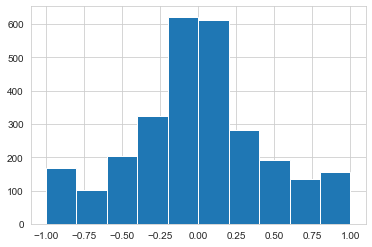

In [22]:
plt.style.use({'figure.facecolor':'white'})
plt.hist(a)

# Random Brickwork

In [53]:
num_qubit = 4

def construct_random_brickwork_func(num_steps, be):
    num_qubit = 4
    rb = construct_mbl_circuit(num_qubit, [], 0, num_steps, completely_random=True)
    rb = transpile(rb, backend=be, optimization_level=3)
    return rb

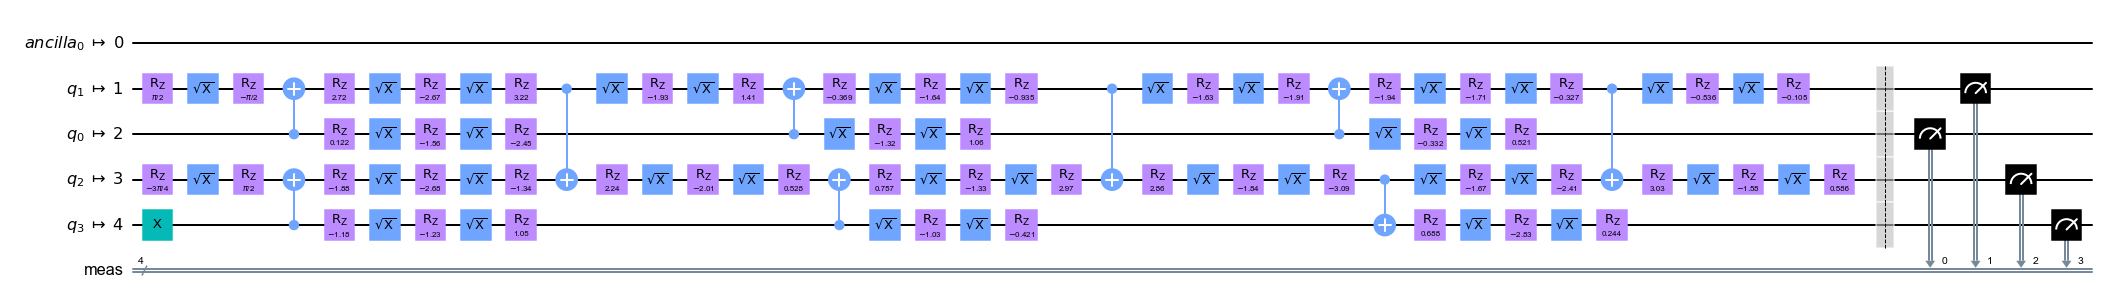

In [52]:
construct_random_brickwork_func(3, be=backend_noisy).draw('mpl', fold=-1)

In [ ]:
steps = [1]
generate_data(construct_random_brickwork_func, steps, './data/haoran_mbd/random_brickwork', 500)

# Random MBD

In [74]:
num_qubit = 4

W = 0.8 * np.pi
theta = 0.1 * np.pi

def construct_random_mbd_func(num_steps, be):
    disorders = generate_disorder(num_qubit, W)
    random_mbl = construct_mbl_circuit(num_qubit, disorders, theta, num_steps)
    circuit = transpile(random_mbl, backend=be, optimization_level=3)
    return circuit, random_mbl

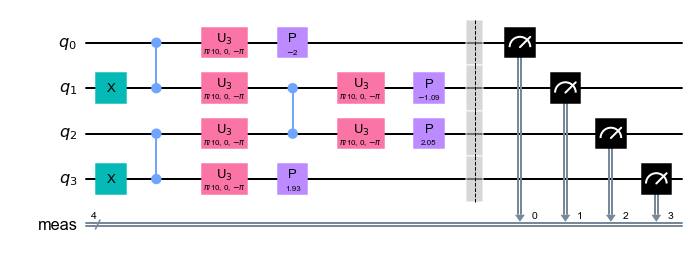

In [77]:
circuit, random_mbl = construct_random_mbd_func(1, backend_noisy)
random_mbl.draw('mpl', fold=-1, idle_wires=False)

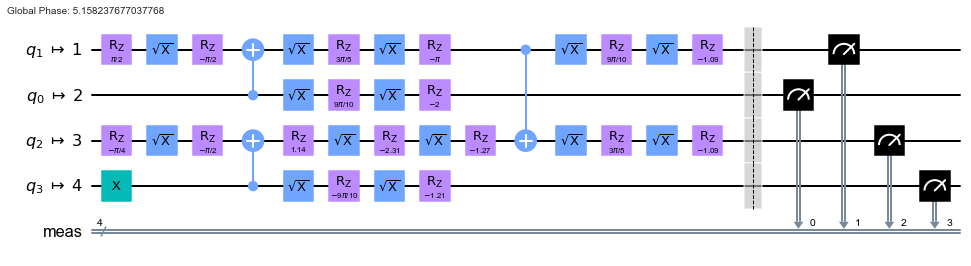

In [78]:
circuit.draw('mpl', fold=-1, idle_wires=False)

In [ ]:
steps = list(range(10))
generate_data(partial(construct_random_mbd_func, be=backend_noisy_coherent), steps, './data/mbd_datasets2/theta_0.1pi_coherent/val', 200)

In [ ]:
with open('./data/mbd_datasets/train/step_5.json', 'r') as in_f:
    train_data = json.load(in_f)
train_data[0]['circuit_graph']

In [ ]:
with open('./data/mbd_datasets/val/step_4.json', 'r') as in_f:
    val_data = json.load(in_f)
val_data[0]['circuit_graph']